# Notebook 7 - Insights on Players and Toxic Behavior




In [ ]:
!pip install sentence-transformers

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
dota = pd.read_csv('gdrive/My Drive/dota_cleaned_labels.csv')
dota.head()

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate
0,0,9,1808.40822,100%,0,0,0,0,0
1,2,6,1238.43090,carry,0,0,0,0,0
2,2,0,1248.42850,yes dog,0,0,0,0,0
3,2,0,1559.05260,yeah,0,0,0,0,0
4,2,0,1563.18490,fast and furious,0,0,0,0,0


In [ ]:
len(dota['text'].values)

6914913

In [ ]:
len(set(dota['text'].values))

## Trying three player profiles: one as non-toxic and two natural clusters within the toxic category

In [ ]:
# Get all toxic labeled texts only, while non-toxic texts are in their own category
general_toxic = dota[dota['toxic']==1]
len(list(set(general_toxic['text'].str.replace("\?|\!", "").str.lower().values)))

In [ ]:
# Clustering the toxic category into two different groups
from sklearn.cluster import KMeans

embedder = SentenceTransformer('distilroberta-base-paraphrase-v1')
corpus = list(set(general_toxic['text'].str.replace("\?|\!", "").str.lower().values))
corpus_embeddings = embedder.encode(corpus)

# K-means
num_clusters = 2
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

for i, cluster in enumerate(clustered_sentences):
    print("Cluster ", i+1)
    print(cluster)
    print("")

In [ ]:
clustered_texts = pd.DataFrame({'text': corpus, 'cluster': cluster_assignment})
clustered_texts.head()

In [ ]:
# # Saving bc clustering took a while to run
# from google.colab import files

# clustered_texts.to_csv('text_clusters.csv', index=False)
# files.download('text_clusters.csv')

In [6]:
clustered_texts = pd.read_csv('gdrive/My Drive/text_clusters.csv')
clustered_texts.head()

,text,cluster
0,do u fuck your pillow,1
1,u mentally sick monkeyt,0
2,so shit delete dota invoker,1
3,still a loser,0
4,stop dance shit,1


In [7]:
# Number of unique texts per cluster
clustered_texts.groupby('cluster').size()

cluster
0    115266
1    117691
dtype: int64

In [8]:
# Adding labels, match, slot, and time data to text and cluster assignment
toxic_clustered = clustered_texts.merge(dota, left_on='text', right_on='text')
toxic_clustered = toxic_clustered[['match', 'slot', 'time', 'text', 'toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'cluster']]  # re-ordering
toxic_clustered.head()

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate,cluster
0,79869,4,482.81546,u mentally sick monkeyt,1,0,0,1,0,0
1,114076,1,1610.40675,so shit delete dota invoker,1,1,0,0,0,1
2,9246,8,1892.59313,still a loser,1,0,0,1,0,0
3,348445,7,1390.43252,still a loser,1,0,0,1,0,0
4,954275,5,1737.41503,still a loser,1,0,0,1,0,0


In [9]:
# Proportions of other labels in cluster 0 along with average time
cluster_0 = toxic_clustered[toxic_clustered['cluster']==0]
cluster_0 = cluster_0[cluster_0['toxic']==1]
cluster_0[['time', 'toxic', 'obscene', 'threat', 'insult', 'identity_hate']].mean()

time             1489.550872
toxic               1.000000
obscene             0.858759
threat              0.000054
insult              0.708355
identity_hate       0.029114
dtype: float64

In [10]:
# Proportions of other labels in cluster 1 along with average time
cluster_1 = toxic_clustered[toxic_clustered['cluster']==1]
cluster_1 = cluster_1[cluster_1['toxic']==1]
cluster_1[['time', 'toxic', 'obscene', 'threat', 'insult', 'identity_hate']].mean()

time             1360.388659
toxic               1.000000
obscene             0.803884
threat              0.016492
insult              0.637405
identity_hate       0.026195
dtype: float64

In [11]:
# Cluster 0 = Name calling
cluster_0.groupby('text').size().sort_values(ascending=False).head(20)

text
bitch                            3699
idiots                           2043
pussy                            1756
stupid                           1632
noob jug idiot dog ugly nigga    1052
moron                             919
loser                             787
fucking noob                      741
bitches                           695
asshole                           689
piece of shit                     565
mother fucker                     545
fuckers                           517
motherfucker                      507
suck it                           503
sick                              475
idiot team                        447
dick                              424
pathetic                          413
fucking retard                    412
dtype: int64

In [12]:
# Cluster 1 = General exclamations that express anger towards someone
cluster_1.groupby('text').size().sort_values(ascending=False).head(20)

text
fuck you            4494
fuck off            3679
shut up             1800
suck my dick         777
retarded             528
you suck             433
fuck you             407
go sex               365
run bitch            363
shut the fuck up     322
end this shit        289
get fucked           261
fuck you all         238
go fuck yourself     227
fuck u all           218
kill yourself        200
i hate u             199
i hate you           196
shut up              195
fuck my team         181
dtype: int64

## What kinds of clusters are made from the toxic messages?
* **Cluster 0: Name calling** (ie. bitch, idiot, pussy, stupid, moron, loser, asshole, piece of shit)
* **Cluster 1: Teammate-targeted offensive phrases** (ie. fuck you, fuck off, suck my dick, you suck, get fucked)
  * Can also be described as non-name calling offensive language

**We can say that these are two types of toxic behaviors.**

## Can we say that these are also two types of toxic players?
To determine this, means of cluster labels will be calculated for each unique player that shares a toxic message.
* If it has a mean of 0, they are a cluster 0 player.
* If it has a mean of 1, they are a cluster 0 player.
* Those with a mean of .5 are both. 
  * If there are a lot of these players (if it's more of a spectrum than classification), then these clusters cannot represent types of players, only types of behavior.

Players with at at least 1 toxic message sent


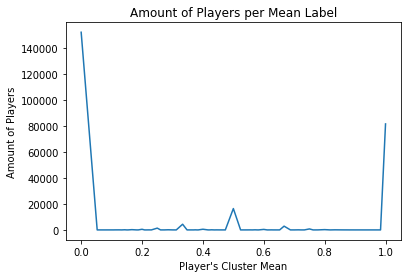

In [43]:
print("Players with at at least 1 toxic message sent")
plt.plot(toxic_clustered.groupby(['match', 'slot']).mean()['cluster'].reset_index().groupby('cluster').size())
plt.xlabel("Player's Cluster Mean")
plt.ylabel("Amount of Players")
plt.title("Amount of Players per Mean Label");

In [40]:
# number of players that have sent at least 1 toxic message
len(toxic_clustered.groupby(['match', 'slot']).mean()['cluster'].reset_index())

262056

Players with more than 1 toxic message sent


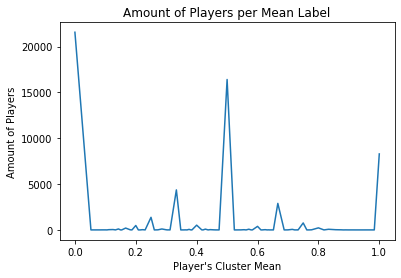

In [44]:
print("Players with more than 1 toxic message sent")
tmp = toxic_clustered.groupby(['match', 'slot']).size() 
plt.plot(toxic_clustered.groupby(['match', 'slot']).mean()['cluster'].loc[tmp[tmp > 1].index].reset_index().groupby('cluster').size())
plt.xlabel("Player's Cluster Mean")
plt.ylabel("Amount of Players")
plt.title("Amount of Players per Mean Label");

In [39]:
# number of players that have sent more than 1 toxic message
len(toxic_clustered.groupby(['match', 'slot']).mean()['cluster'].loc[tmp[tmp > 1].index])

58495

In [47]:
toxic_clustered.groupby(['match', 'slot']).mean()['cluster'].loc[tmp[tmp > 1].index]

match   slot
32      5       0.500000
82      4       0.666667
83      5       0.500000
107     0       0.500000
118     3       0.000000
                  ...   
999932  5       0.000000
999943  6       0.500000
999944  4       0.500000
999952  5       0.285714
999979  2       0.142857
Name: cluster, Length: 58495, dtype: float64

In [53]:
# An example of mean cluster = .05
toxic_clustered[(toxic_clustered['match']==107) & (toxic_clustered['slot']==0)]

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate,cluster
177001,107,0,1435.21617,bitch,1,1,0,1,0,0
219938,107,0,1245.26257,i fuck your mum,1,1,0,1,0,1


## We can also say these are two types of players. 
* In the 1st mean label plot, the set of players are extremely dominated by cluster 0 and cluster 1 and not much inbetween.
* The 2nd mean label plot is of players that have sent more than 1 toxic message in a match. The difference in the amount of players between these two plots is around 204,000 players. 
  * This means that a huge portion of players that send toxic messages only send it once. Since this is where the larger portion of toxic messages reside, it is arguable that plot 1 should be more important.

## We can even say there are three types of players.
* On the other hand, it is also arguable that plot 2 should be considered more important because it contains consistently toxic players.
* **Given this, toxic players can be separated into 3 different profiles:**
  1. **Name callers** (cluster 0: "bitch", "asshole", "piece of shit")
  2. **Teammate-targeted offensive phrases / non-name callers** (cluster 1: "fuck you", "suck my dick")
  3. **Players who offend people in both ways** (cluster .5: "bitch" and "i fuck your mum")

## This section shows how non-toxic messages can be clustered into two.
### Overall, the two clusters do not show and distinguishing features for non-toxic messages/players.

In [ ]:
non_toxic = dota[dota['toxic']==0]
non_toxic['text'] = non_toxic['text'].str.lower().str.replace("\?|\!", "")
non_toxic = non_toxic.groupby('text').size().sort_values(ascending=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
len(non_toxic)

2551568

In [ ]:
non_unique_messages = non_toxic[non_toxic > 10]  # texts sent more than 10 times within 2.5 million non-toxic texts
non_unique_messages

text
lol                     310932
xd                      121991
gg wp                   117508
ggwp                     97236
wp                       83454
                         ...  
saklap                      11
reported for feeding        11
shir                        11
buyback more                11
i can't play                11
Length: 29062, dtype: int64

In [ ]:
embedder = SentenceTransformer('distilroberta-base-paraphrase-v1')
corpus = list(set(non_unique_messages.index))
corpus_embeddings = embedder.encode(corpus)

# K-means
num_clusters = 2
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(corpus_embeddings)
cluster_assignment = clustering_model.labels_

clustered_sentences = [[] for i in range(num_clusters)]
for sentence_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append(corpus[sentence_id])

In [ ]:
nontoxic_clustered = pd.DataFrame({"sentence": corpus, "cluster": cluster_assignment})
nontoxic_clustered.head()

,sentence,cluster
0,,1
1,this veno,1
2,rat dota best dota,0
3,run,1
4,a low,1


In [ ]:
# from google.colab import files

# nontoxic_clustered.to_csv('nontoxic_text_clusters.csv', index=False)
# files.download('nontoxic_text_clusters.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Adding labels, match, slot, and time info to text and cluster assignments
nontoxic_clusters = nontoxic_clustered.merge(dota, left_on='sentence', right_on='text')
nontoxic_clusters = nontoxic_clusters[['match', 'slot', 'time', 'text', 'toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'cluster']]  # re-ordering
nontoxic_clusters.head()

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate,cluster
0,38129,3,672.56914,this veno,0,0,0,0,0,1
1,96081,2,1942.91240,this veno,0,0,0,0,0,1
2,99028,9,2583.98700,this veno,0,0,0,0,0,1
3,122949,2,1609.74025,this veno,0,0,0,0,0,1
4,131570,4,2448.30150,this veno,0,0,0,0,0,1


In [ ]:
# non-toxic cluster 0
cluster_0 = nontoxic_clusters[nontoxic_clusters['cluster']==0]
cluster_0

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate,cluster
19,63758,0,2206.33813,rat dota best dota,0,0,0,0,0,0
20,71103,8,1961.95310,rat dota best dota,0,0,0,0,0,0
21,79360,6,3296.75110,rat dota best dota,0,0,0,0,0,0
22,139359,9,2845.00623,rat dota best dota,0,0,0,0,0,0
23,158931,0,2648.20436,rat dota best dota,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2540443,869280,4,1573.98236,wp wp gl next,0,0,0,0,0,0
2540444,881645,8,3603.47888,wp wp gl next,0,0,0,0,0,0
2540445,922879,8,2275.22400,wp wp gl next,0,0,0,0,0,0
2540446,936839,0,3898.58723,wp wp gl next,0,0,0,0,0,0


In [ ]:
# non-toxic cluster 1
cluster_1 = nontoxic_clusters[nontoxic_clusters['cluster']==1]
cluster_1

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate,cluster
0,38129,3,672.56914,this veno,0,0,0,0,0,1
1,96081,2,1942.91240,this veno,0,0,0,0,0,1
2,99028,9,2583.98700,this veno,0,0,0,0,0,1
3,122949,2,1609.74025,this veno,0,0,0,0,0,1
4,131570,4,2448.30150,this veno,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2540512,628980,1,881.08485,you mad bro,0,0,0,0,0,1
2540513,730781,9,2355.51780,you mad bro,0,0,0,0,0,1
2540514,752261,9,788.07428,you mad bro,0,0,0,0,0,1
2540515,915879,9,2147.90687,you mad bro,0,0,0,0,0,1


In [ ]:
cluster_0.groupby('text').size().sort_values(ascending=False).head(20)

text
gg wp       96838
ggwp        75152
wp          65079
rofl        33666
lmao        24090
pls         21344
ff          21207
:(          17848
report      15023
commend      9068
plz          6366
sf           6240
kk           5937
gl next      5405
reported     4922
gg wp        4674
end pls      4619
bg           4483
ggg          4378
pudge        4293
dtype: int64

In [ ]:
cluster_1.groupby('text').size().sort_values(ascending=False).head(20)

text
lol           240242
end            52001
wtf            35181
ok             34115
(              24893
nice           19936
noob           16261
yes            12721
wait           12713
yeah           11042
go end          9940
go              9679
commend me      8652
sorry           8397
wew             8286
bye             7882
please          7880
why             7081
dude            6852
mid             6835
dtype: int64

* No apparent differences in the natural clusters of non-toxic messages/players.


_______

# Time Segmenting

In [54]:
dota.head()

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate
0,0,9,1808.40822,100%,0,0,0,0,0
1,2,6,1238.43090,carry,0,0,0,0,0
2,2,0,1248.42850,yes dog,0,0,0,0,0
3,2,0,1559.05260,yeah,0,0,0,0,0
4,2,0,1563.18490,fast and furious,0,0,0,0,0


In [55]:
dota['time'].min(), dota['time'].max()

(-1011.525424, 7897.6530200000025)

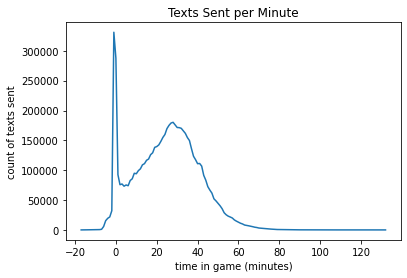

In [56]:
# time in minutes
time_bin = dota.copy()
time_bin['time'] = round(time_bin['time'] / 60)
time_bin['time'] = time_bin['time'].apply(int)

# counts of texts sent within each minute
time_sizes = time_bin.groupby('time').size()
plt.plot(time_sizes)
plt.xlabel('time in game (minutes)')
plt.ylabel('count of texts sent')
plt.title('Texts Sent per Minute');

In [57]:
time_sizes.sort_values(ascending=False).head(15)

time
-1     331069
 0     287638
 28    180223
 27    179038
 29    175873
 26    175130
 30    171547
 31    171294
 32    170176
 25    169698
 33    166002
 34    161732
 24    159821
 23    154880
 35    154721
dtype: int64

* There is a huge spike in messages within -1 to 0 minutes into the game (hero selection phase).
* Aside from that, most messages are being sent around 28-32 minutes into the game (generally mid-game).

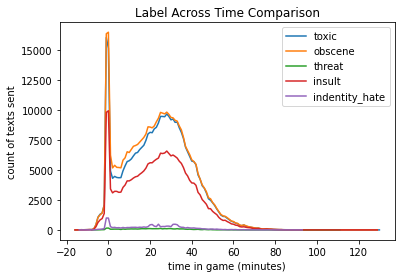

In [58]:
toxic_sizes = time_bin[time_bin['toxic']==1].groupby('time').size()
obscene_sizes = time_bin[time_bin['obscene']==1].groupby('time').size()
threat_sizes = time_bin[time_bin['threat']==1].groupby('time').size()
insult_sizes = time_bin[time_bin['insult']==1].groupby('time').size()
identity_sizes = time_bin[time_bin['identity_hate']==1].groupby('time').size()

plt.plot(toxic_sizes, label="toxic")
plt.plot(obscene_sizes, label="obscene")
plt.plot(threat_sizes, label="threat")
plt.plot(insult_sizes, label="insult")
plt.plot(identity_sizes, label="indentity_hate")
plt.legend()
plt.xlabel('time in game (minutes)')
plt.ylabel('count of texts sent')
plt.title("Label Across Time Comparison");

## Bins of 5 Minutes

In [59]:
time_bin.head()

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate
0,0,9,30,100%,0,0,0,0,0
1,2,6,21,carry,0,0,0,0,0
2,2,0,21,yes dog,0,0,0,0,0
3,2,0,26,yeah,0,0,0,0,0
4,2,0,26,fast and furious,0,0,0,0,0


In [60]:
# time in multiples of 5
binned = time_bin.copy()
binned['time'] = 5 * round(binned['time'] / 5)
binned['time'] = binned['time'].astype(int)
binned.head()

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate
0,0,9,30,100%,0,0,0,0,0
1,2,6,20,carry,0,0,0,0,0
2,2,0,20,yes dog,0,0,0,0,0
3,2,0,25,yeah,0,0,0,0,0
4,2,0,25,fast and furious,0,0,0,0,0


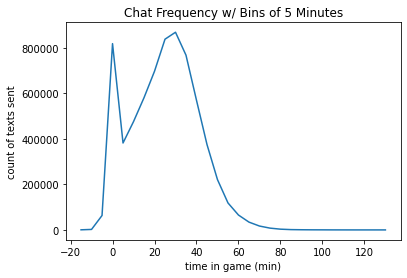

In [61]:
# count of messages sent per 5 minutes
plt.plot(binned.groupby('time').size().index, binned.groupby('time').size().values)
plt.xlabel('time in game (min)')
plt.ylabel('count of texts sent')
plt.title("Chat Frequency w/ Bins of 5 Minutes");

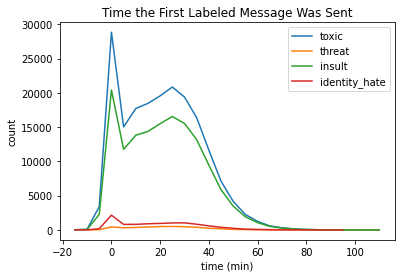

In [62]:
plt.plot(binned[binned['toxic']==1].groupby('match').first().groupby('time').size(), label='toxic')
plt.plot(binned[binned['threat']==1].groupby('match').first().groupby('time').size(), label='threat')
plt.plot(binned[binned['insult']==1].groupby('match').first().groupby('time').size(), label='insult')
plt.plot(binned[binned['identity_hate']==1].groupby('match').first().groupby('time').size(), label='identity_hate')
plt.legend()
plt.xlabel('time (min)')
plt.ylabel('count')
plt.title("Time the First Labeled Message Was Sent");

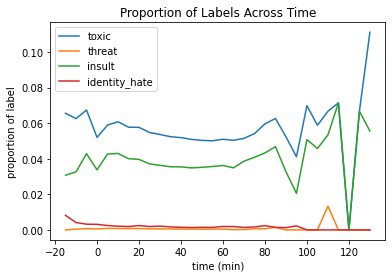

In [63]:
# proportion of messages with the label across time
label_means = binned.groupby('time').mean()
plt.plot(label_means['toxic'], label='toxic')
plt.plot(label_means['threat'], label='threat')
plt.plot(label_means['insult'], label='insult')
plt.plot(label_means['identity_hate'], label='identity_hate')
plt.legend()
plt.xlabel('time (min)')
plt.ylabel('proportion of label')
plt.title("Proportion of Labels Across Time");

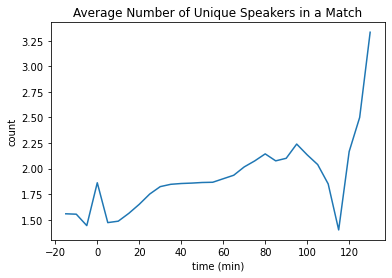

In [64]:
# avg unique number of speakers in a match across time
num_speakers = binned.groupby(['match', 'slot', 'time']).size().reset_index()[['match', 'slot', 'time']]
num_speakers = num_speakers.groupby(['match', 'time']).size()
plt.plot(num_speakers.reset_index().groupby('time').mean().drop('match', axis=1)[0])
plt.xlabel('time (min)')
plt.ylabel('count')
plt.title('Average Number of Unique Speakers in a Match');

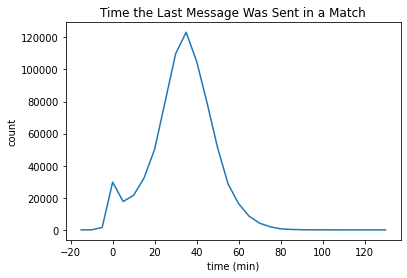

In [65]:
# times where the last message was sent in each match 
plt.plot(binned.groupby('match').last().groupby('time').size())
plt.xlabel('time (min)')
plt.ylabel('count')
plt.title("Time the Last Message Was Sent in a Match");

* The peak above is also when a game potentially ends generally.
  * The spike is probably the multiple "gg" and "wp"s.

## More Complex Analysis (TF-IDF) - Game Phase Bins
* Larger bins will be used so there is more data within each bin: Pre-game, Early game, Mid game, and Late game
* These terms are very dependent on gameplay and do not have a set-in-stone timeframe.
* Generally, they are... (https://www.reddit.com/r/DotA2/comments/81rjz4/when_is_early_mid_or_lategame/dv4r8q9/?utm_source=reddit&utm_medium=web2x&context=3)
  * Pre-game: negative minutes
  * Early game: 0-15 minutes
  * Mid game: 16-35 minutes
  * Late game: 36+ minutes

In [66]:
# Binning time by pre, early, mid, and late game
time_bin.loc[time_bin['time'] < 0, 'time'] = -1
time_bin.loc[(time_bin['time'] >= 0) & (time_bin['time'] <= 15), 'time'] = 0
time_bin.loc[(time_bin['time'] >= 16) & (time_bin['time'] <= 35), 'time'] = 1
time_bin.loc[(time_bin['time'] >= 36), 'time'] = 2

time_bin['time'] = time_bin['time'].astype(str)
time_bin.loc[time_bin['time'] == '-1', 'time'] = 'pre'
time_bin.loc[time_bin['time'] == '0', 'time'] = 'early'
time_bin.loc[time_bin['time'] == '1', 'time'] = 'mid'
time_bin.loc[time_bin['time'] == '2', 'time'] = 'late'
time_bin.head()

,match,slot,time,text,toxic,obscene,threat,insult,identity_hate
0,0,9,mid,100%,0,0,0,0,0
1,2,6,mid,carry,0,0,0,0,0
2,2,0,mid,yes dog,0,0,0,0,0
3,2,0,mid,yeah,0,0,0,0,0
4,2,0,mid,fast and furious,0,0,0,0,0


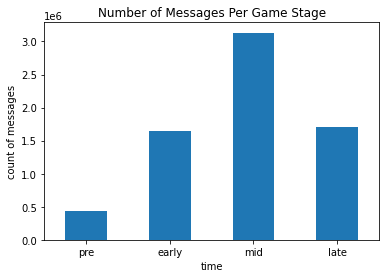

In [67]:
# num rows per bin
order = ['pre', 'early', 'mid', 'late']
time_bin.groupby('time').size().loc[order].plot(kind='bar', rot=0)
plt.ylabel('count of messages')
plt.title('Number of Messages Per Game Stage');

## Getting the Most Prominent Words Per Phase of All Messages

In [68]:
from sklearn.feature_extraction.text import TfidfVectorizer

# training on text of every phase
tfidf = TfidfVectorizer(stop_words='english')
corpus = list(set(time_bin['text'].values))

X = tfidf.fit_transform(corpus)
feature_names = np.array(tfidf.get_feature_names())

In [69]:
def get_top_tf_idf_words(response, top_n=2):
    sorted_nzs = np.argsort(response.data)[:-(top_n+1):-1]
    return feature_names[response.indices[sorted_nzs]]

# applying it to pre-game phase
new_doc = list(set(time_bin[time_bin['time']=='pre']['text'].values))
responses = tfidf.transform(new_doc)

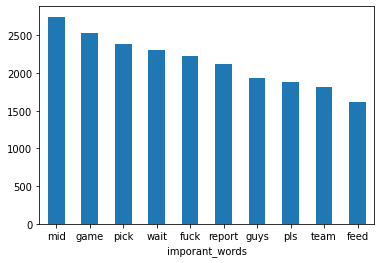

In [70]:
important_pre = [get_top_tf_idf_words(response,2) for response in responses]
total_pre = []
for x in important_pre:
  for y in x:
    total_pre.append(y)

pre_words = pd.DataFrame({'imporant_words': total_pre}).groupby('imporant_words').size().sort_values(ascending=False)
pre_words[:10].plot(kind='bar', rot=0);

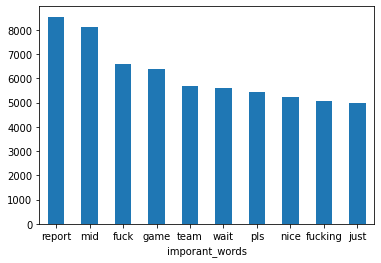

In [71]:
# applying it to early game phase
new_doc = list(set(time_bin[time_bin['time']=='early']['text'].values))
responses = tfidf.transform(new_doc)

important_early = [get_top_tf_idf_words(response,2) for response in responses]
total_early = []
for x in important_early:
  for y in x:
    total_early.append(y)

early_words = pd.DataFrame({'imporant_words': total_early}).groupby('imporant_words').size().sort_values(ascending=False)
early_words[:10].plot(kind='bar', rot=0);

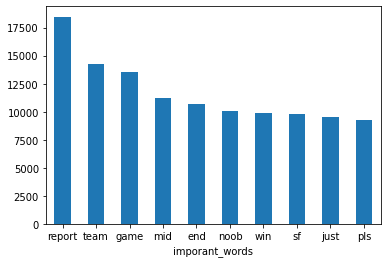

In [72]:
# applying it to mid game phase
new_doc = list(set(time_bin[time_bin['time']=='mid']['text'].values))
responses = tfidf.transform(new_doc)

important_mid = [get_top_tf_idf_words(response,2) for response in responses]
total_mid = []
for x in important_mid:
  for y in x:
    total_mid.append(y)

mid_words = pd.DataFrame({'imporant_words': total_mid}).groupby('imporant_words').size().sort_values(ascending=False)
mid_words[:10].plot(kind='bar', rot=0);

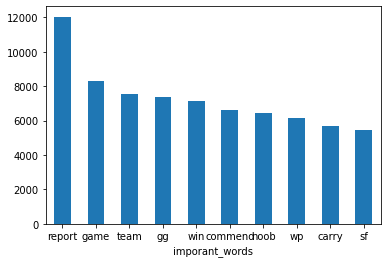

In [73]:
# applying it to late game phase
new_doc = list(set(time_bin[time_bin['time']=='late']['text'].values))
responses = tfidf.transform(new_doc)

important_late = [get_top_tf_idf_words(response,2) for response in responses]
total_late = []
for x in important_late:
  for y in x:
    total_late.append(y)

late_words = pd.DataFrame({'imporant_words': total_late}).groupby('imporant_words').size().sort_values(ascending=False)
late_words[:10].plot(kind='bar', rot=0);

## Most Prominent Words Per Phase of Toxic Messages

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


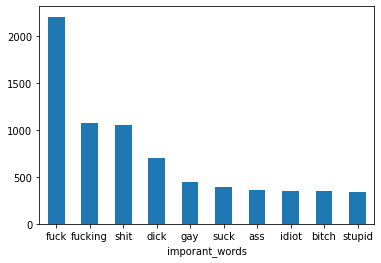

In [74]:
# pre toxic
new_doc = list(set(time_bin[time_bin['time']=='pre'][time_bin['toxic']==1]['text'].values))
responses = tfidf.transform(new_doc)

important_pre = [get_top_tf_idf_words(response,2) for response in responses]
total_pre = []
for x in important_pre:
  for y in x:
    total_pre.append(y)

pre_words = pd.DataFrame({'imporant_words': total_pre}).groupby('imporant_words').size().sort_values(ascending=False)
pre_words[:10].plot(kind='bar', rot=0);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


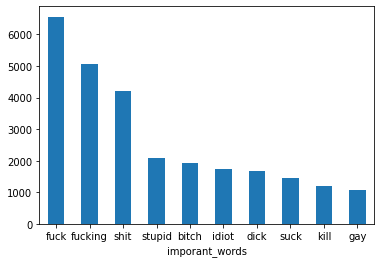

In [75]:
# early toxic
new_doc = list(set(time_bin[time_bin['time']=='early'][time_bin['toxic']==1]['text'].values))
responses = tfidf.transform(new_doc)

important_early = [get_top_tf_idf_words(response,2) for response in responses]
total_early = []
for x in important_early:
  for y in x:
    total_early.append(y)

early_words = pd.DataFrame({'imporant_words': total_early}).groupby('imporant_words').size().sort_values(ascending=False)
early_words[:10].plot(kind='bar', rot=0);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


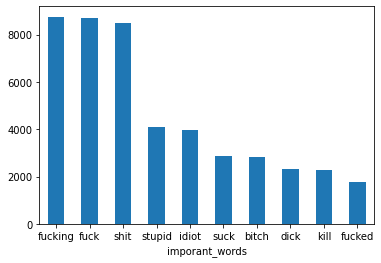

In [76]:
# mid toxic
new_doc = list(set(time_bin[time_bin['time']=='mid'][time_bin['toxic']==1]['text'].values))
responses = tfidf.transform(new_doc)

important_mid = [get_top_tf_idf_words(response,2) for response in responses]
total_mid = []
for x in important_mid:
  for y in x:
    total_mid.append(y)

mid_words = pd.DataFrame({'imporant_words': total_mid}).groupby('imporant_words').size().sort_values(ascending=False)
mid_words[:10].plot(kind='bar', rot=0);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


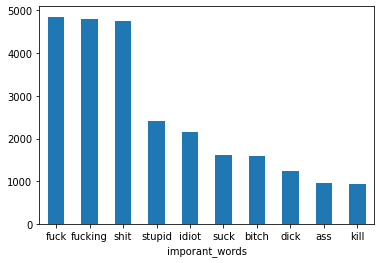

In [77]:
# late toxic
new_doc = list(set(time_bin[time_bin['time']=='late'][time_bin['toxic']==1]['text'].values))
responses = tfidf.transform(new_doc)

important_late = [get_top_tf_idf_words(response,2) for response in responses]
total_late = []
for x in important_late:
  for y in x:
    total_late.append(y)

late_words = pd.DataFrame({'imporant_words': total_late}).groupby('imporant_words').size().sort_values(ascending=False)
late_words[:10].plot(kind='bar', rot=0);

## Most Prominent Words For Threat, Insult, and Identity_hate During Mid Game
* For each of these labels, the most prominent words per phase were the same each time, so only mid will be looked at since it contains the most data.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


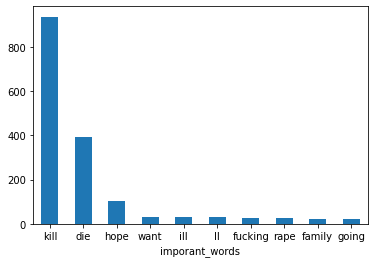

In [78]:
# mid threat
new_doc = list(set(time_bin[time_bin['time']=='mid'][time_bin['threat']==1]['text'].values))
responses = tfidf.transform(new_doc)

important_mid = [get_top_tf_idf_words(response,2) for response in responses]
total_mid = []
for x in important_mid:
  for y in x:
    total_mid.append(y)

mid_words = pd.DataFrame({'imporant_words': total_mid}).groupby('imporant_words').size().sort_values(ascending=False)
mid_words[:10].plot(kind='bar', rot=0);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


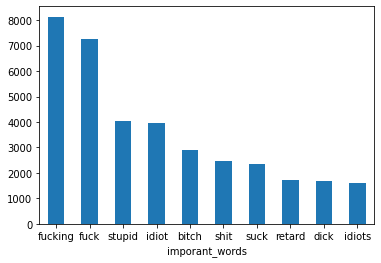

In [79]:
# mid insult
new_doc = list(set(time_bin[time_bin['time']=='mid'][time_bin['insult']==1]['text'].values))
responses = tfidf.transform(new_doc)

important_mid = [get_top_tf_idf_words(response,2) for response in responses]
total_mid = []
for x in important_mid:
  for y in x:
    total_mid.append(y)

mid_words = pd.DataFrame({'imporant_words': total_mid}).groupby('imporant_words').size().sort_values(ascending=False)
mid_words[:10].plot(kind='bar', rot=0);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


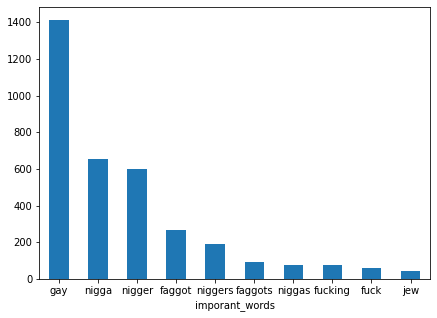

In [80]:
# mid identity_hate
new_doc = list(set(time_bin[time_bin['time']=='mid'][time_bin['identity_hate']==1]['text'].values))
responses = tfidf.transform(new_doc)

important_mid = [get_top_tf_idf_words(response,2) for response in responses]
total_mid = []
for x in important_mid:
  for y in x:
    total_mid.append(y)

mid_words = pd.DataFrame({'imporant_words': total_mid}).groupby('imporant_words').size().sort_values(ascending=False)
plt.figure(figsize=(7,5))
mid_words[:10].plot(kind='bar', rot=0);